# COMPAS Dataset Analysis

### AAEs Analysis

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mlp_to_qbaf_converter.mlp_to_qbaf import MLPToQBAF
import Uncertainpy.src.uncertainpy.gradual as grad
from mlp_to_qbaf_converter.argument_attribution_explanation import AAE
from mlp_to_qbaf_converter.relation_attribution_explanation import RAE
from mlp_to_qbaf_converter.utils import plot_qbaf
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr
import joblib

We have trained MLP Classifers for the COMPAS dataset on various hidden layer sizes. We have then translated to QBAFs and computed the AAE gradient score for each of the above models and different levels of sparification. We have then compared the most important argument (neuron) between the sparsifed and original models, evaluating whether the most important neuron is the same in both models.

The sparsification levels are: 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%

In [2]:
max_argument_mlp_dict = {}
gradient_scores_dict = {}
rankings_dict = {}
removal_impacts_dict = {}


for mlp in Path("../../outputs/compas/aae").glob("*_gradient.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_gradient","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    max_argument_mlp_dict[mlp_size] = data["max_arguments"]
    gradient_scores_dict[mlp_size] = data["top_scores"]
    rankings_dict[mlp_size] = data["rankings"]
    removal_impacts_dict[mlp_size] = data["impacts"]
    

mlp10
mlp10_10
mlp40
mlp25_25
mlp60
mlp5_5
mlp30
mlp30_30
mlp15_15
mlp80
mlp20_20
mlp20
mlp70
mlp50


In [3]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
header_shrink = [("Shrink", f"{percent}%") for percent in shrink_percentages]
results_df = pd.DataFrame(columns=[("", "Hidden Layers"), ("", "Total No. Neurons"), ("", "Depth")] + header_shrink)
results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)
sizes = []
depths = []
totals = []

for i, mlp in enumerate(max_argument_mlp_dict):
    size = tuple(map(int, str(mlp)[3:].split("_")))
    sizes.append(size)
    depth = len(size)
    depths.append(depth)
    total_neurons = sum(size)
    totals.append(total_neurons)


    results_df.loc[i, ("", "Hidden Layers")] = str(size)
    results_df.loc[i, ("", "Total No. Neurons")] = total_neurons
    results_df.loc[i, ("", "Depth")] = depth

    results_df.loc[i, header_shrink] = max_argument_mlp_dict[mlp]

In [4]:
# from IPython.display import HTML
# HTML(results_df.style.set_table_styles(
#     [{'selector': 'th', 'props': [('text-align', 'center')]}]
# ).to_html(index=False))


results_df

Shrink                        \
   Hidden Layers Total No. Neurons Depth        10%        20%        30%   
0          (10,)                10     1  99.209202  97.915169  95.902229   
1       (10, 10)                20     2  84.399712  69.518332  53.918045   
2          (40,)                40     1  71.387491  53.342919   50.46729   
3       (25, 25)                50     2  92.810927  85.549964  65.636233   
4          (60,)                60     1  99.712437  98.634076  98.634076   
5         (5, 5)                10     2  87.850467  87.850467  62.185478   
6          (30,)                30     1  98.634076   98.05895  97.196262   
7       (30, 30)                60     2  92.307692  87.706686  61.538462   
8       (15, 15)                30     2   97.98706  91.516894  53.055356   
9          (80,)                80     1  97.699497  97.699497  97.699497   
10      (20, 20)                40     2  66.283249  55.499641  29.115744   
11         (20,)                20     1  98.274623  97.124371  95.470884   
12         (70,)                70     1  98.130841  97.555715   94.10496   
13         (50,)                50     1  99.784328  99.209202  99.137311   

                                                                      
          40%        50%        60%        70%        80%        90%  
0   94.967649  93.170381  91.732566    93.0266  97.627606      100.0  
1   39.899353  17.109993  15.312725   8.339324  20.560748   20.77642  
2   40.690151  24.802301  16.391086   7.476636   7.476636     6.9734  
3    30.69734   9.992811  12.221423  12.149533   9.345794  13.515457  
4   98.562185   97.05248  95.902229  93.170381  81.955428  49.317038  
5   62.976276  37.311287  37.311287  37.311287  37.311287  37.311287  
6   95.974119  94.751977  90.941769  79.726815  37.886413   8.339324  
7   34.579439  14.450036   3.235083   4.385334   2.228613   6.470165  
8   32.278936    9.92092   0.215672   1.222142   0.071891  14.665708  
9   97.627606  97.268152   92.09202  86.843997  79.439252  47.951114  
10  10.783609   2.803738   3.810208  14.593817  22.286125  25.521208  
11  93.601725  92.379583  91.804457  92.163911  92.523364  94.320633  
12  92.379583  91.732566  89.503954  87.419123  86.987779  87.059669  
13  99.065421  98.418404  97.483825  96.621136  96.549245  82.314881

In [5]:
max_arg_results = []

for shrink_percentage in header_shrink:
    avg = results_df[shrink_percentage].mean()
    max_arg_results.append(avg)
    print(f"Average for {shrink_percentage[1]} Sparsification: {avg.mean()}")

print(f"Latex row: {"&".join([str(round(x, 1)) for x in max_arg_results])} \\\\")


Average for 10% Sparsification: 91.74797165451369
Average for 20% Sparsification: 86.9415631097874
Average for 30% Sparsification: 75.29013043031735
Average for 40% Sparsification: 66.00595666016227
Average for 50% Sparsification: 55.7974735544829
Average for 60% Sparsification: 52.71130738420459
Average for 70% Sparsification: 51.032145424668784
Average for 80% Sparsification: 48.01786998048679
Average for 90% Sparsification: 42.46687891547705
Latex row: 91.7&86.9&75.3&66.0&55.8&52.7&51.0&48.0&42.5 \\


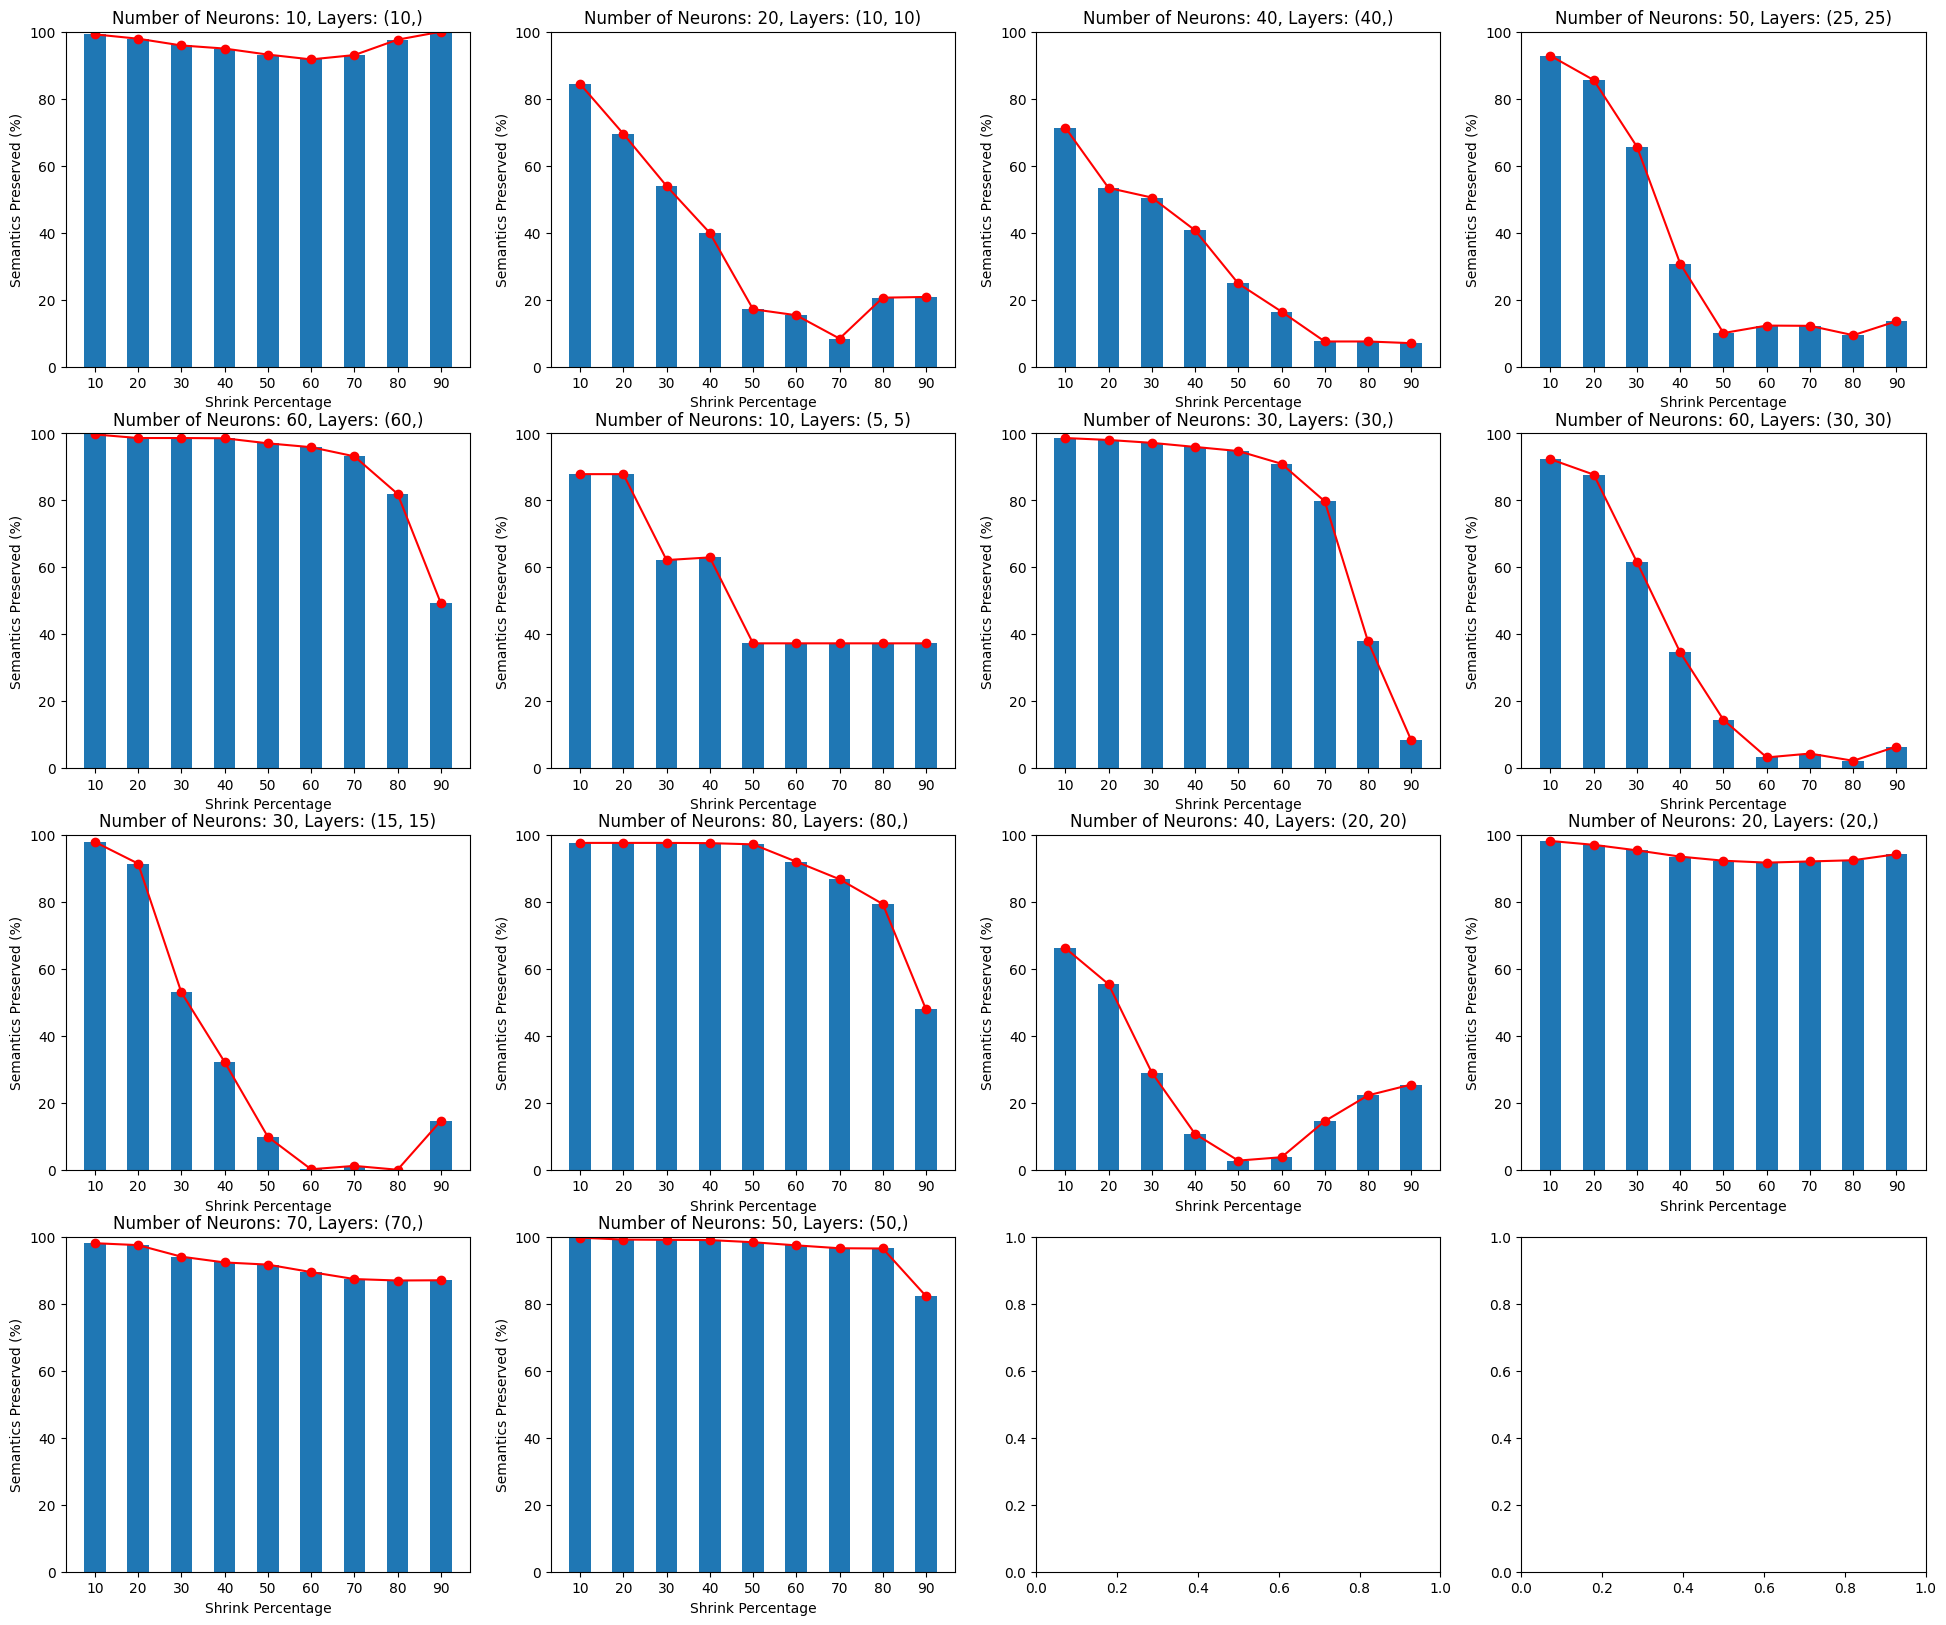

In [6]:
import math

num_sizes = len(sizes)
cols = min(4, math.ceil(math.sqrt(num_sizes)))
rows = math.ceil(num_sizes / cols)
fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

for i, size in enumerate(sizes):
    ax[i//cols, i%cols].bar(shrink_percentages, results_df.iloc[i, 3:], width=5)
    ax[i//cols, i%cols].plot(shrink_percentages, results_df.iloc[i, 3:], marker="o", color="red")
    ax[i//cols, i%cols].set_title(f"Number of Neurons: {totals[i]}, Layers: {size}")
    ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
    ax[i//cols, i%cols].set_ylabel("Semantics Preserved (%)")
    ax[i//cols, i%cols].set_ylim(0, 100)
    ax[i//cols, i%cols].set_xticks(shrink_percentages)


In [7]:
# depths_unique = np.unique(depths)
# depths_unique_sorted_idx = np.argsort(depths_unique)
# depths_unique = depths_unique[depths_unique_sorted_idx]
# average_preserved_depth = np.zeros((len(depths_unique), len(shrink_percentages)))

# for i, depth in enumerate(depths_unique):
#     average_preserved_depth[i] = np.mean(results_df[results_df[("", "Depth")] == depth].iloc[:, 3:], axis=0)

# rows = math.ceil(math.sqrt(len(depths_unique)))
# cols = math.ceil(len(depths_unique) / rows)
# fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

# for i, depth in enumerate(depths_unique):
#     ax[i//cols, i%cols].bar(shrink_percentages, average_preserved_depth[i], width=5)
#     ax[i//cols, i%cols].plot(shrink_percentages, average_preserved_depth[i], marker="o", color="red")
#     ax[i//cols, i%cols].set_title(f"Depth (Number Hidden Layers): {depth}")
#     ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
#     ax[i//cols, i%cols].set_ylabel("Semantics Preserved Average (%)")
#     ax[i//cols, i%cols].set_ylim(0, 100)
#     ax[i//cols, i%cols].set_xticks(shrink_percentages)

# plt.show()

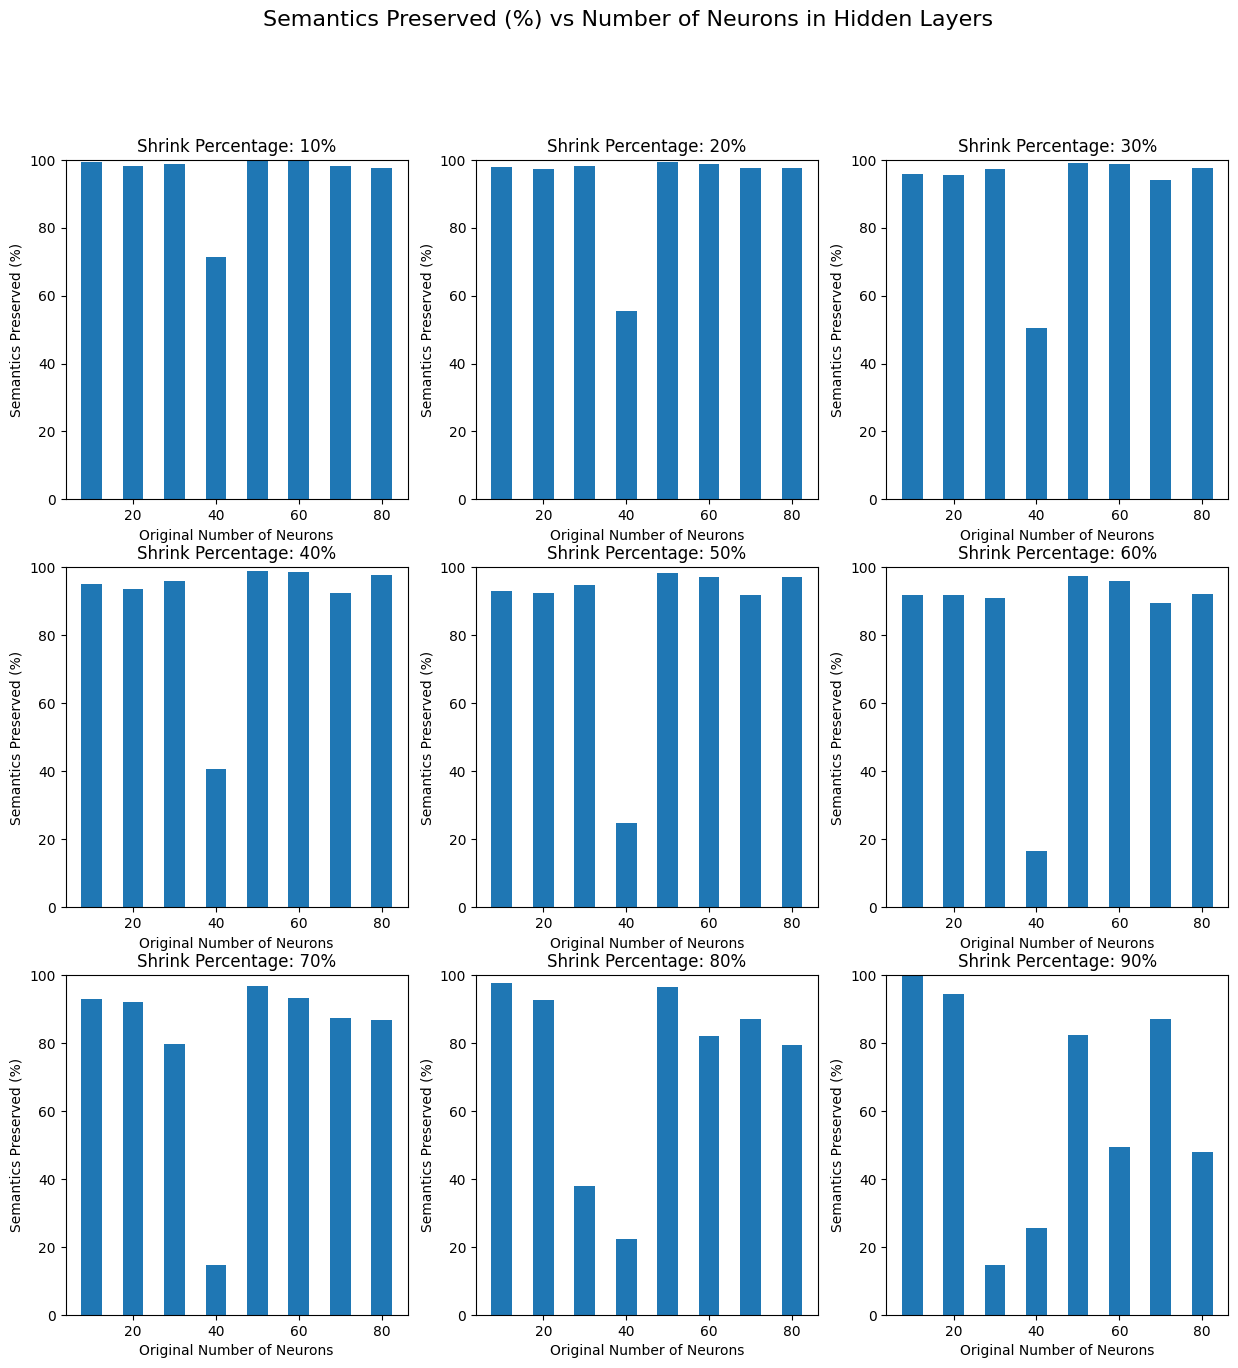

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

totals_sorted_idx = np.argsort(totals)
totals_sorted = np.array(totals)[totals_sorted_idx]

for i, shrink_percentage in enumerate(shrink_percentages):

    percents = results_df.iloc[:, i+3].to_numpy()[totals_sorted_idx]
    
    ax[i//3, i%3].bar(totals_sorted, percents, width=5)
    # ax[i//3, i%3].plot(totals_sorted, percents, marker="o", color="red", linewidth=0.5, markersize=2)
    ax[i//3, i%3].set_title(f"Shrink Percentage: {shrink_percentage}%")
    ax[i//3, i%3].set_xlabel("Original Number of Neurons")
    ax[i//3, i%3].set_ylabel("Semantics Preserved (%)")
    ax[i//3, i%3].set_ylim(0, 100)

# fig.tight_layout()
fig.suptitle("Semantics Preserved (%) vs Number of Neurons in Hidden Layers", fontsize=16)
plt.show()


Further ideas:
<!-- - Track back the most important argument in the sparsifed network to see how much each of the input features contributed to this () -->
- Repeat using other types of AAE (e.g. removal scores)
- Repeat on other datasets, see if we get similar results (maybe later)
- Repeat this style of analysis on RAEs (time complexity issues for SHAP scores if MLPs are large)
- Start researching LRP to find some metrics to check faithfulness of explanations
    - Removal of neurons -> removing the most important neuron should have the biggest impact on the output
    - Perturbation of neurons -> perturbing the most important neuron should have the biggest impact on the output
    - Compare the faithfulness of the explanations before and after sparsification



- Coefficient $\checkmark$
- Ranking (weighting) -> score for cluster and original average
- AAEs
- Other AAE types

In [9]:
kendalltau_coeffs_dict = {}
spearman_coeffs_dict = {}

for mlp in gradient_scores_dict:
    kendalltau_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    spearman_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    top_scores = gradient_scores_dict[mlp]
    for example in range(top_scores.shape[0]):
        for sparse_percent in range(1, top_scores.shape[1]):
            kendalltau_coeffs[example, sparse_percent - 1] = kendalltau(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]
            spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]

            # Deal with the case where the top scores are the same
            # If the top scores are all the same, then the correlation is 1
            # Otherwise, it is 0
            if np.isnan(kendalltau_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    kendalltau_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    kendalltau_coeffs[example, sparse_percent - 1] = 0.0
            
            if np.isnan(spearman_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    spearman_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    spearman_coeffs[example, sparse_percent - 1] = 0.0

    kendalltau_coeffs_dict[mlp] = kendalltau_coeffs
    spearman_coeffs_dict[mlp] = spearman_coeffs
    

/tmp/ipykernel_2724191/912873563.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]


In [10]:

headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
kendalltaucoefficients_df = pd.DataFrame(columns=headers)

for mlp in kendalltau_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(kendalltau_coeffs_dict[mlp], axis=0)))
    kendalltaucoefficients_df.loc[len(kendalltaucoefficients_df)] = row

kendalltaucoefficients_df.sort_values("Number of Neurons", inplace=True)

In [11]:
kendalltaucoefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.998978,0.998927,0.998941,0.998951,0.999108,0.999129,0.999144,0.999223,0.998909
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.996287,0.995891,0.995596,0.995991,0.996168,0.996175,0.995987,0.996333,0.996255


In [12]:
headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
spearman_coefficients_df = pd.DataFrame(columns=headers)

for mlp in spearman_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(spearman_coeffs_dict[mlp], axis=0)))
    spearman_coefficients_df.loc[len(spearman_coefficients_df)] = row

spearman_coefficients_df.sort_values("Number of Neurons", inplace=True)

In [13]:
spearman_coefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.999491,0.999454,0.999486,0.999491,0.999591,0.999599,0.999604,0.999654,0.999510
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.998325,0.998383,0.998273,0.998277,0.998559,0.998414,0.998464,0.998714,0.998487


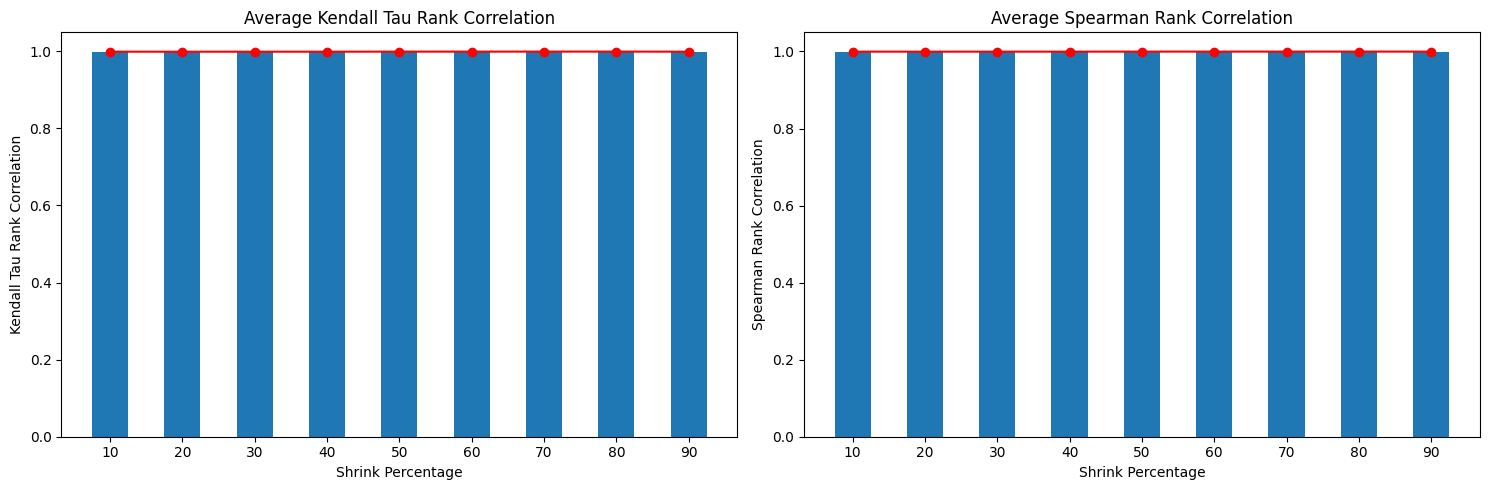

In [14]:
average_kendalltau_ranks = np.zeros((len(shrink_percentages)))

for mlp in kendalltau_coeffs_dict:
    average_kendalltau_ranks += np.mean(kendalltau_coeffs_dict[mlp], axis=0)

average_kendalltau_ranks /= len(kendalltau_coeffs_dict)

average_spearman_ranks = np.zeros((len(shrink_percentages)))

for mlp in spearman_coeffs_dict:
    average_spearman_ranks += np.mean(spearman_coeffs_dict[mlp], axis=0)

average_spearman_ranks /= len(spearman_coeffs_dict)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(shrink_percentages, average_kendalltau_ranks, width=5)
ax[0].plot(shrink_percentages, average_kendalltau_ranks, marker="o", color="red")
ax[0].set_title("Average Kendall Tau Rank Correlation")
ax[0].set_xlabel("Shrink Percentage")
ax[0].set_ylabel("Kendall Tau Rank Correlation")
# ax[0].set_ylim(0, 1)
ax[0].set_xticks(shrink_percentages)
# ax[0].axhline(0, color="black")

ax[1].bar(shrink_percentages, average_spearman_ranks, width=5)
ax[1].plot(shrink_percentages, average_spearman_ranks, marker="o", color="red")
ax[1].set_title("Average Spearman Rank Correlation")
ax[1].set_xlabel("Shrink Percentage")
ax[1].set_ylabel("Spearman Rank Correlation")
# ax[1].set_ylim(0, 1)
ax[1].set_xticks(shrink_percentages)
plt.tight_layout()
plt.show()

In [15]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)


In [16]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

In [17]:
top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,92.753415,88.120058,83.798341,78.852145,73.018055,68.826127,64.553436,60.026916,52.625872
max,97.843278,97.836089,95.247224,95.175333,86.225737,84.651330,89.072610,89.072610,89.072610
min,85.305536,79.094177,75.046729,67.987060,59.511143,48.813803,37.411934,30.481668,31.180035


In [18]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)


In [19]:
rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,3.555959,5.792301,8.630256,10.889013,14.286890,17.228425,20.976108,25.337743,31.330900
max,5.766099,7.348818,11.435577,14.255759,19.069681,21.661308,28.089150,35.738318,38.452912
min,2.523270,3.923832,6.998350,8.246125,11.198090,14.365210,16.158486,16.917006,16.917006


In [20]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

In [21]:
top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,99.840813,99.604601,98.521105,96.939509,94.079285,92.615795,91.100955,86.756701,82.094074
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
min,98.777858,97.268152,86.843997,76.204170,52.695902,54.924515,49.892164,31.056794,6.398275


In [22]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

In [23]:
pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.994444,0.994205,0.993378,0.991878,0.990806,0.990553,0.986774,0.984734,0.925800
max,0.999947,0.999705,0.999104,0.998882,0.999243,0.999483,0.998969,0.999382,0.998817
min,0.979854,0.983918,0.981720,0.981339,0.980865,0.980875,0.930014,0.930014,0.434908


In [24]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)


In [25]:
kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.995056,0.994862,0.994276,0.993300,0.992429,0.992202,0.988696,0.986706,0.914519
max,0.999003,0.998859,0.998585,0.997833,0.998342,0.998431,0.998213,0.998845,0.997437
min,0.985559,0.988220,0.986866,0.986584,0.986097,0.985959,0.938387,0.938387,0.469638


#### Creating a faithfulness score

In SpArX, evalaute faithfulness using a structural faithfulness score and input-output faithfuless. 

Do something similar by looking at the impact of removal of the most important argument on the strength of the topic argument. If the strength after removal is roughly the same in both then this shows the sparsification is faithful (similar to input/output faithfulness).

Structural faithfulness: Create a score based on how close the averaged rankings are to the sparse rankings -> large difference = lower structural faithfulness.

Next steps: Compare to ML methods -> just compute AAEs on input arguments

### RAEs Analysis

![RAE Illustration](RAE_Illustration.png)


In [26]:
rankings_dict = {}
rankings_variances_dict = {}
rankings_weighted_dict = {}
non_averaged_rankings_percents = {}
non_averaged_kendalltau_coeffs_dict = {}
non_averaged_pearson_coeffs_dict = {}

for mlp in Path("../../outputs/compas/rae").glob("*_shap.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_shap","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    rankings_dict[mlp_size] = data["rankings"]

    try:
        non_averaged_rankings_percents[mlp_size] = data["non_averaged_rankings"]
        rankings_weighted_dict[mlp_size] = data["rankings_weighted"]
        rankings_variances_dict[mlp_size] = data["rankings_variances"]
        non_averaged_kendalltau_coeffs_dict[mlp_size] = data["kendall_taus"]
        non_averaged_pearson_coeffs_dict[mlp_size] = data["pearson_correlations"]
    except Exception:
        # Haven't been calculated yet
        continue

mlp4_4
mlp6
mlp5
mlp2
mlp4
mlp3


In [27]:
def remove_relation_type(arr):
    for i in range(len(arr)):
        if "Attack" in arr[i]:
            arr[i] = arr[i].replace("Attack(", "").replace(")", "")
        else:
            arr[i] = arr[i].replace("Support(", "").replace(")", "")

    return arr 

shrink_percentages = [20, 40, 60, 80]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)

Defining Preservation:
- Does the disribution of the RAEs stay the same? KL Divergence/ Wasserstein distance 
- Are the highest ranked relations the same? When the scores of the corresponding relations are averaged, do the top relations stay the same?

In [28]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,31.019479,41.569785,52.100407,62.380610
max,68.316730,68.316730,69.230769,69.559413
min,8.368081,20.992092,28.806614,52.100236


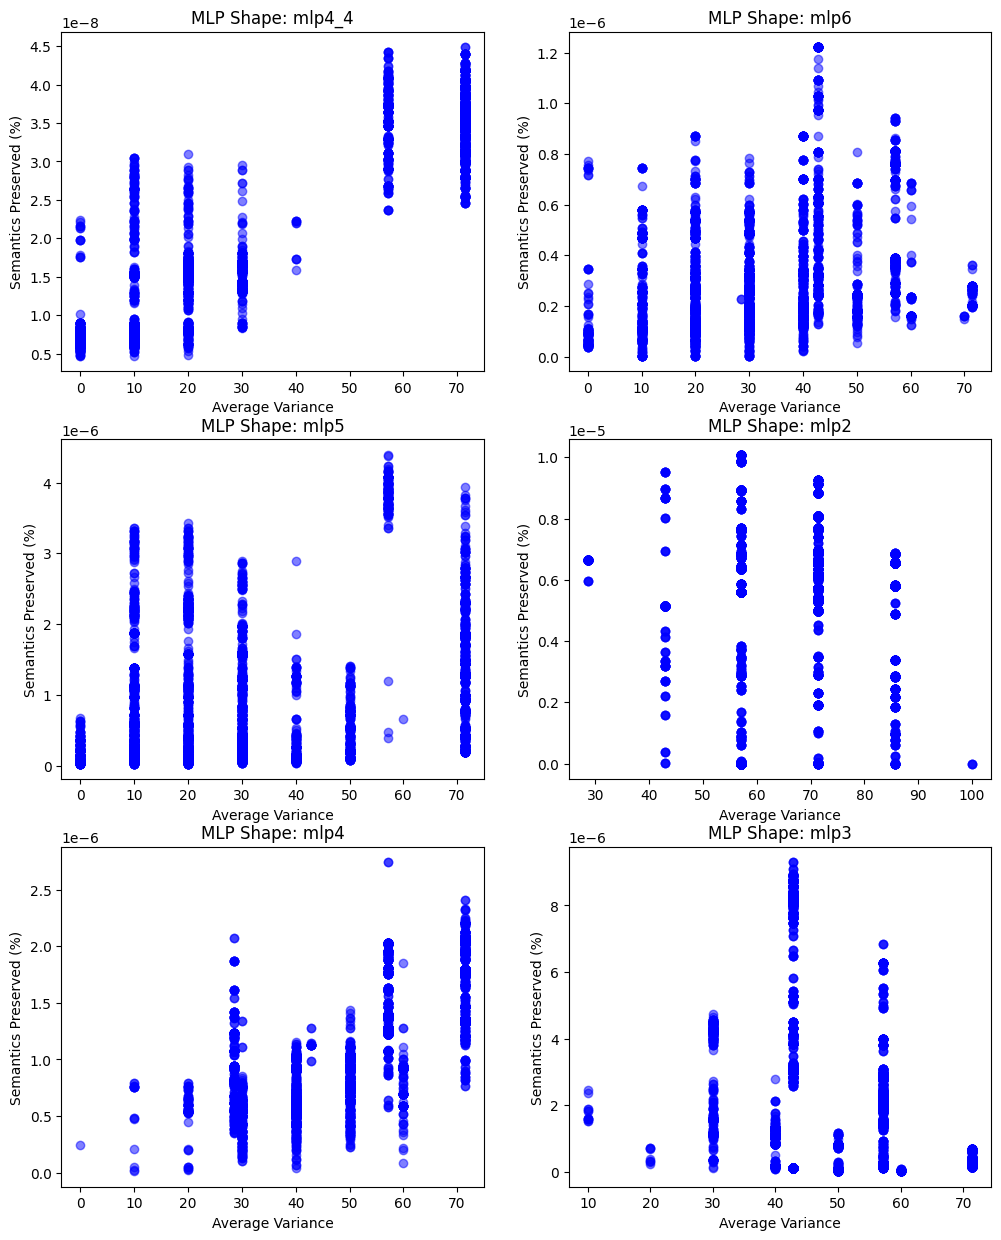

In [29]:
rows = math.ceil(math.sqrt(len(rankings_dict)))
cols = math.ceil(len(rankings_dict) / rows)

fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

mean_variances = np.zeros((len(rankings_variances_dict), len(shrink_percentages)))

for m, mlp in enumerate(rankings_variances_dict):
    var_dict_tmp = np.zeros((len(rankings_variances_dict[mlp]), len(shrink_percentages)))
    avg_variances = []
    avg_preservations = []
    for example in range(len(rankings_variances_dict[mlp])):
        for sparse_percent in range(len(rankings_variances_dict[mlp][example])):
            # Convert the data to float before calculating the mean
            variances = rankings_variances_dict[mlp][example][sparse_percent, 0][:, 1].astype(float)
            avg_variance = np.mean(variances)

            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1

            preservation = count_same_rankings / top_n * 100

            avg_variances.append(avg_variance)
            avg_preservations.append(preservation)

            var_dict_tmp[example, sparse_percent] = avg_variance
    
    mean_variances[m] = np.mean(var_dict_tmp, axis=0)

    ax[m//cols, m%cols].scatter(avg_preservations, avg_variances, color="blue", alpha=0.5)
    ax[m//cols, m%cols].set_title(f"MLP Shape: {mlp}")
    ax[m//cols, m%cols].set_xlabel("Average Variance")
    ax[m//cols, m%cols].set_ylabel("Semantics Preserved (%)")
    # ax[m//cols, m%cols].set_ylim(0, 100)
            
plt.show()

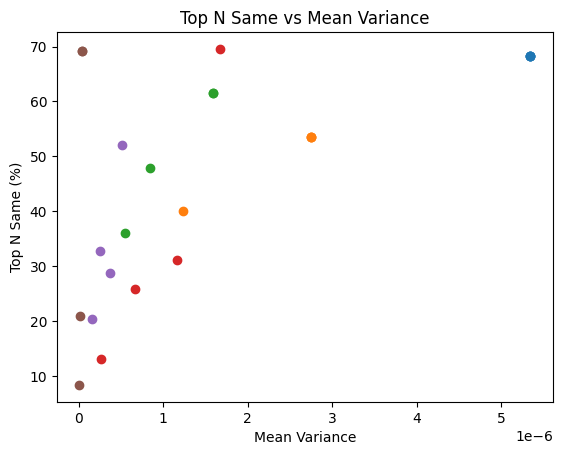

In [30]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
rankings_variances_df = pd.DataFrame(columns=headers)
rankings_variances_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["Number of Hidden Layers"] = [len(x) for x in rankings_variances_df["MLP Shape"]]
rankings_variances_df[headers[3:]] = mean_variances
rankings_variances_df.sort_values("Number of Neurons", inplace=True)

for mlp in rankings_variances_df["MLP Shape"]:
    
    plt.scatter(rankings_variances_df[rankings_variances_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0], top_n_same_df[top_n_same_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0])


plt.xlabel("Mean Variance")
plt.ylabel("Top N Same (%)")
plt.title("Top N Same vs Mean Variance")

plt.show()

In [31]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)

rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})


,20%,40%,60%,80%
mean,32.748899,29.990791,30.076752,28.670420
max,37.086272,36.950850,34.433090,32.103611
min,23.113602,23.113602,23.113602,23.113602


In [32]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,27.929547,53.618500,64.042655,82.650371
max,97.771387,97.771387,100.000000,100.000000
min,2.444285,0.431344,15.528397,55.068296


In [33]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.838034,0.804611,0.786248,0.779455
max,0.999506,0.998998,0.998710,0.999881
min,0.254643,0.058746,-0.038730,-0.038730


In [34]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)

kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.877144,0.853032,0.838218,0.834831
max,0.994665,0.991043,0.990387,0.999402
min,0.456262,0.306641,0.225652,0.225652


In [35]:
average_top_same_df = pd.DataFrame(columns=headers)
average_top_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["Number of Hidden Layers"] = [len(x) for x in average_top_same_df["MLP Shape"]]
average_top_same_df[headers[3:]] = [np.mean(non_averaged_rankings_percents[x], axis=0) for x in non_averaged_rankings_percents]
average_top_same_df.sort_values("Number of Neurons", inplace=True)

average_top_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,12.471044,9.912932,8.993330,9.618979
max,53.055356,53.055356,53.055356,53.055356
min,0.000000,0.000000,0.000000,0.000000


In [36]:
non_averaged_kendall = np.zeros((len(non_averaged_kendalltau_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_kendalltau_coeffs_dict):

    non_averaged_kendall[m] = np.mean(non_averaged_kendalltau_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_kendall_df = pd.DataFrame(columns=headers)
non_averaged_kendall_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_kendall_df["MLP Shape"]]
non_averaged_kendall_df[headers[3:]] = non_averaged_kendall
non_averaged_kendall_df.sort_values("Number of Neurons", inplace=True)

In [37]:
non_averaged_kendall_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.986606,0.981803,0.974660,0.971320
max,0.990717,0.987097,0.983081,0.980346
min,0.980346,0.975140,0.959397,0.959397


In [38]:
non_averaged_pearson = np.zeros((len(non_averaged_pearson_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_pearson_coeffs_dict):
    non_averaged_pearson[m] = np.mean(non_averaged_pearson_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_pearson_df = pd.DataFrame(columns=headers)
non_averaged_pearson_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_pearson_df["MLP Shape"]]
non_averaged_pearson_df[headers[3:]] = non_averaged_pearson
non_averaged_pearson_df.sort_values("Number of Neurons", inplace=True)

In [39]:
non_averaged_pearson_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.835126,0.802487,0.799044,0.798419
max,0.985626,0.981346,0.954775,0.961502
min,0.698172,0.596564,0.568019,0.568019
